In [1]:
from mendeleev import element
from mendeleev import isotope
import scipy as sci
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import warnings
#suppress warnings
warnings.filterwarnings('ignore')
import scipy.constants as constant
import numpy as np

In [2]:
# Parameters for the calculation of the reaction rates
SIGV_PARAMS = [
    # [a1, a2, a3, a4, a5, a6, a7]
    [-38.5922, -0.00630249, 1.25159, -8.86637, 1.78419, -0.198181, 1.92028], # Reaction 2
    [-46.8616, -0.00295519, -3.23527, 1.42088, -0.126344, 0.00974799, -0.178045], # Reaction 3
    [-42.1159, 0.0101979, -6.1653, 10.9227, -0.654152, 0.0352096, -3.41782], # Reaction 4
    [-43.1056, 0.0150095, -6.85042, 12.3633, -0.638696, 0.0261701, -4.16095], # Reaction 5
    [-34.1675, -0.523, 4.63833e-10, -1.67345e-9, 1.85876e-10, -1.70346e-11, -0.666667], # Reaction 6
    [-31.7974, -0.0137498, -5.56986, -14.1977, 2.27582, -0.19545, 2.92443], # Reaction 7
    [-34.1075, -0.000673532, 0.0793345, -0.532712, 0.13522, -0.00748114, 0.104904], # Reaction 8
    [-34.8617, -1.72, -4.68818e-9, 1.21488e-8, -1.10092e-9, 8.94955e-11, -0.5], # Reaction 9
    [-38.9414, -0.000245919, -12.7758, -0.489479, -0.0881085, 0.00557341, -0.582926], # Reaction 10
    [-32.5903, -0.0032998, -7.83923, -2.1531, 0.133483, -0.00732414, 0.20178], # Reaction 11
    [-32.3946, 9.06317e-7, -2.04247e-9, -1.167, -4.39104e-10, 3.41812e-11, -1.98589e-9] # Reaction 12
]



In [3]:
#Konstanten
#Temperatur in GK
#Masse in MeV
kB=0.0861734 #in MeV/GK
kBG=0.0861734 *10**(-3) #in GeV/GK
hsc=1.97327 * 10**(-11) #in MeV*cm
hscG=hsc*10**(-3) #in GeV*cm
c=sci.constants.c #in cm/s
pi=sci.constants.pi
muc2= 931.494 # in MeV
lambda_beta=0.00113443 #in s^-1
nu=6.2 * 10**(-10) #dimensionless

## Hilfsmittel und Konstanten

In [4]:
def contains_slash(string): #To write spin from mendeleev to floats
    if "/" in string:
        return True
    else:
        return False

def Spin_to_float(j):
    if (contains_slash(j)==True):
        # Split the string into two parts using the forward slash
        parts = j.split("/")
        # Convert the numerator and denominator to floats
        numerator = float(parts[0])
        denominator = float(parts[1])
        # Divide the numerator by the denominator
        result = numerator / denominator
        return result
    
    else:
        return float(j)

In [5]:
class Particle:
    def __init__(self,mass,Z,A,j,number):
        self.mass = mass * 1.66053906660*10**(-27)
        self.Z = Z
        self.A = A
        self.spin = Spin_to_float(j)
        self.number=number

In [6]:
def kron_delta(part1,part2): #kroenecker delta for a and b
    if part1.number == part2.number:
        return 1
    else:
        return 0

In [7]:
neutron=Particle(1.00866491595, 0,1,'1/2',0)
H1= Particle(isotope(1, 1).mass,1,1,isotope(1, 1).spin,1) 
H2= Particle(isotope(1, 2).mass,1,2,isotope(1, 2).spin,2)
H3=Particle(isotope(1, 3).mass,1, 3,isotope(1, 3).spin,3)
He3=Particle(isotope(2, 3).mass,2, 3,isotope(2, 3).spin,4)
He4=Particle(isotope(2, 4).mass,2, 4,isotope(2, 4).spin,5)
Li7=Particle(isotope(3, 7).mass,3, 7,isotope(3, 7).spin,6)
Be7=Particle(isotope(4, 7).mass,4, 7,isotope(4,7).spin,7)

#Just in case it becomes more comfortable to write them like this:
n=neutron
p=H1 
d=H2
t=H3
al=He4

List_Isotopes=[neutron,H1,H2,H3,He3,He4,Li7,Be7]


In [8]:
Y_n0=1*10**9   #Busca donde lo pone
Y_H10=0
Y_H20=0
Y_H30=0
Y_He30=0
Y_He40=4
Y_Li70=0
Y_Be70=0


Menge_liste=[Y_n0,Y_H10,Y_H20,Y_H30,Y_He30,Y_He40,Y_Li70,Y_Be70]


## Nicht-Differentialgleichungen

In [9]:

def n_Variable(T): #T in GK 
    return nu*(2*sci.special.zeta(3)*(kB*T)**3)/(np.pi *hsc)**3 #in cm**-3



In [10]:
def ov_T(T,r_number): #T in GK, ov in cm**3/s**-1
    a1, a2,a3,a4,a5,a6,a7=SIGV_PARAMS[r_number-2]#Since the first (1st) reaction beta decay is, the parameters for the 2nd reaction are saved in [0]
    return np.exp(a1 + a2/T + a3*T**(-1/3) + a4*T**(1/3) + a5*T +a6*T**(5/3) + a7*np.log(T)) 

def lambda_gamma(T,part1,part2,part3,r_number):#T in GK
    Term1=(muc2*kB*T/(2*pi**2 * hsc**2))**(3/2) #muc2*kB*T in MeV**2 , hsc**2 in (in MeV*cm)**2 #dimensionless
    Term2=(2*part1.spin +1)*(2*part2.spin +1)/(2*part3.spin +1) #dimensionless
    Term3=(part1.A*part2.A/part3.A)**(3/2) #dimensionless
    Q=(part1.mass + part2.mass - part3.mass)*muc2 # in MeV  
    Term4=(Q)/(kB*T) #Q in MeV, (kB*T) in MeV    dimensionless
    Term5=ov_T(T,r_number)/(1+kron_delta(part1,part2))
    tog=Term1*Term2*Term3*Term4*Term5  #in cm**3/s**-1
    return tog



In [11]:
def ov_cd(T,part1,part2,part3,part4,r_number):
    Term1=(1+kron_delta(part3,part4))/(1+kron_delta(part1,part2))#dimensionless 
    Term2=(2*part1.spin +1)*(2*part2.spin +1)/((2*part3.spin +1)*(2*part4.spin +1))#dimensionless 
    Term3=(part1.A*part2.A/(part3.A*part4.A))**(3/2)#dimensionless 
    Q=(part1.mass + part2.mass - part3.mass - part4.mass)*muc2 #in MeV
    Term4=(Q*10**-3)/(kB*T)
    tog=Term1*Term2*Term3*Term4* ov_T(T,r_number)
    return tog

In [12]:
def T(t):
    return 14.0/np.sqrt(t)

#don't know if it is necessary

In [13]:
def r_number_to_reaction_particles(r_number):
    if r_number == 1:
        return [neutron, 0, H1, 0]
    elif r_number==2:
        return [p,n,H2,0]
    elif r_number==3:
        return [d,p,He3,0]
    elif r_number==4:
        return [d,d,n,He3]
    elif r_number==5:
        return [d,d,p,t]
    elif r_number==6:
        return [t,d,n,He4]
    elif r_number==7:
        return [t,al,Li7,0]
    elif r_number==8:
        return [He3,n,p,t]
    elif r_number==9:
        return [He3,d,p,He4]
    elif r_number==10:
        return [He3,al,Be7,0]
    elif r_number==11:
        return [Li7,p,al,He4]
    elif r_number==12:
        return [Be7,neutron,p,Li7]
    else:
        print("Not a valid reaction number")
        return [0,0,0,0]


## Differentialgleichungen

In [14]:
def dt_to_dT(T):
    return -T**3 /392,0 

In [15]:
def drv_beta_decay(N_liste): #Das ist für dydt
    Ya=N_liste[0]
    Yc=N_liste[1]
    return [-Ya*lambda_beta, Ya*lambda_beta]


In [16]:
def drv_gammapart(T,N_liste,part1,part2,part3,r_number): #Das ist für dydt     
    Ya = N_liste[part1.number]
    Yb = N_liste[part2.number]
    Yc = N_liste[part3.number]
    dYa=-Ya*Yb*n_Variable(T)*ov_T(T,r_number)+(1+kron_delta(part1,part2))*lambda_gamma(T,part1,part2,part3,r_number)*Yc
    dYb=-Ya*Yb*n_Variable(T)*ov_T(T,r_number)+(1+kron_delta(part1,part2))*lambda_gamma(T,part1,part2,part3,r_number)*Yc
    dYc=Ya*Yb*n_Variable(T)*ov_T(T,r_number)/(1+kron_delta(part1,part2))-lambda_gamma(T,part1,part2,part3,r_number)*Yc
    return np.array([dYa, dYb, dYc])

In [17]:
def drv_fourthpart(T,N_liste,part1,part2,part3,part4,r_number): #Das ist für dydt
    Ya = N_liste[part1.number]
    Yb = N_liste[part2.number]
    Yc = N_liste[part3.number]
    Yd = N_liste[part4.number]
    Term1 =-Ya * Yb * n_Variable(T) * ov_T(T,r_number)
    Term2 = (1 + kron_delta(part1, part2)) / (1 + kron_delta(part3, part4)) *  n_Variable(T) * Yc * Yd * ov_cd(T,part1, part2, part3, part4,r_number)
    Term3 = (1 + kron_delta(part3, part4)) / (1 + kron_delta(part1, part2)) * Ya * Yb * n_Variable(T) * ov_T(T,r_number)
    Term4 =-Yc * Yd * ov_cd(T,part1, part2, part3, part4,r_number) *  n_Variable(T) 
    dYa=Term1+Term2
    dYb=Term1+Term2
    dYc=Term3+Term4
    dYd=Term3+Term4
    
    return np.array([dYa, dYb, dYc,dYd])

In [59]:
def master_equation_for_dT(T, N_liste):
    dN_liste = [0, 0, 0, 0, 0, 0, 0, 0]
    
    for i in range(1, 2): #if i in range(1, n>8) Error message 
        particles = r_number_to_reaction_particles(i)
        r_number = i
        
        if i == 1:
            dN_liste[0] =dN_liste[0] + -392 / (T ** 3) * drv_beta_decay(N_liste)[0] 
            dN_liste[1] =dN_liste[1] + -392 / (T ** 3) * drv_beta_decay(N_liste)[1]

        else:
            if particles[3] == 0:
                dY_gamma=drv_gammapart(T, N_liste, particles[0], particles[1], particles[2], r_number)
                num_a=particles[0].number #for better visibility
                num_b=particles[1].number
                num_c=particles[2].number
                
                dN_liste[num_a] =dN_liste[num_a] + -392 / (T ** 3) * dY_gamma[0]
                dN_liste[num_b] =dN_liste[num_b] + -392 / (T ** 3) * dY_gamma[1]
                dN_liste[num_c] =dN_liste[num_c] + -392 / (T ** 3) * dY_gamma[2]
            else:
                num_a=particles[0].number #for better visibility
                num_b=particles[1].number
                num_c=particles[2].number
                num_d=particles[3].number
                
                dY_four_particles=drv_fourthpart(T, N_liste, particles[0], particles[1], particles[2], particles[3], r_number)
                dN_liste[num_a] =dN_liste[num_a] + -392 / (T ** 3) * dY_four_particles[0]
                dN_liste[num_b] =dN_liste[num_b] + -392 / (T ** 3) * dY_four_particles[1]
                dN_liste[num_c] =dN_liste[num_c] + -392 / (T ** 3) * dY_four_particles[2]
                dN_liste[num_d] =dN_liste[num_d] + -392 / (T ** 3) * dY_four_particles[3]
    
    return dN_liste



In [60]:
master_equation_for_dT(9, Menge_liste)

[610008.9986282579, -610008.9986282579, 0, 0, 0, 0, 0, 0]

In [61]:
T_span=[9,0.1]
#suppress warnings

sol = solve_ivp(master_equation_for_dT, T_span, Menge_liste, method="Radau")

In [62]:
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 9.000e+00  9.000e+00 ...  1.021e-01  1.000e-01]
        y: [[ 1.000e+09  1.000e+09 ...  5.466e-01  2.214e-01]
            [ 0.000e+00  1.414e-03 ...  1.000e+09  1.000e+09]
            ...
            [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 389
     njev: 12
      nlu: 54

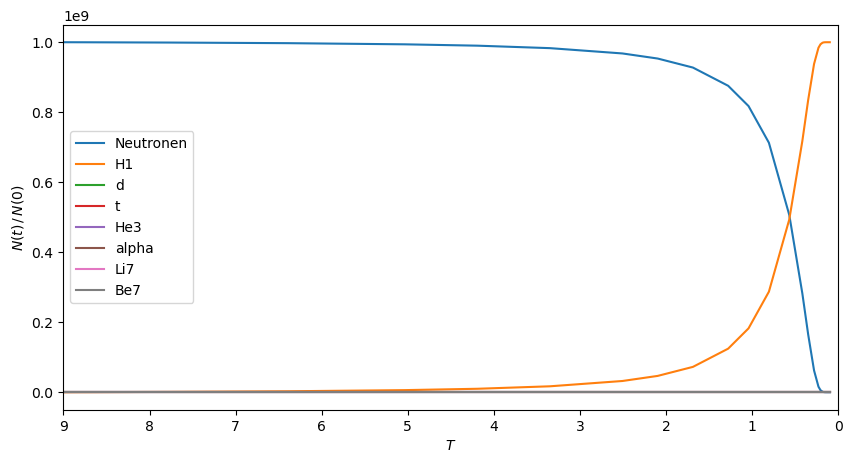

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 5))
plt.xlabel("$T$")
plt.ylabel("$N(t)\,/\,N(0)$")
plt.plot(sol.t, sol.y[0], label = "Neutronen")
plt.plot(sol.t, sol.y[1], label = "H1")
plt.plot(sol.t, sol.y[2], label = "d")
plt.plot(sol.t, sol.y[3], label = "t")
plt.plot(sol.t, sol.y[4], label = "He3")
plt.plot(sol.t, sol.y[5], label = "alpha")
plt.plot(sol.t, sol.y[6], label = "Li7")
plt.plot(sol.t, sol.y[7], label = "Be7")
plt.xlim(9, 0)
plt.legend()
plt.show()